<span style="font-size:36px"><b>Baseline Model Tutorial</b></span>

Copyright &copy; 2020 Gunawan Lumban Gaol

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language overning permissions and limitations under the License.

# Import Packages

In [22]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ipywidgets import interact
import tensorflow as tf
import tensorflow.keras.backend as K
print("tf.__version__ = "+tf.__version__)

from gurih.data.data_generator import DataGenerator, get_y_true_data_generator, validate_dataset_dir
from gurih.models.decoder import CTCDecoder
from gurih.models.model import BaselineASRModel
from gurih.models.utils import CharMap, wer

%load_ext autoreload
%autoreload 2

tf.__version__ = 2.1.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set documentation directory and model weights directory.

In [23]:
model_dir = "../../models/Model010a/"  # to store model weights
doc_dir = "../../docs/Model010a/"  # to store model configuration and evaluation

if not os.path.exists(model_dir): os.makedirs(model_dir)
if not os.path.exists(doc_dir): os.makedirs(doc_dir)

Also specify `train`, `validation`, and `test` dataset directories. 

These directories should contain all `.npz` and its corresponding `.txt` transcriptions files with same naming conventions. For example if npz filename is `0.npz`, then the transcription txt filename should be `0.txt`.

In [24]:
train_dir = "../../dataset/interim/Model010a/train/"
valid_dir = "../../dataset/interim/Model010a/valid/"

In [25]:
validate_dataset_dir(train_dir)
validate_dataset_dir(valid_dir)

../../dataset/interim/Model-010a/train/ checks passed.
../../dataset/interim/Model-010a/valid/ checks passed.


# Model Training

Define constant for ASR Model.

In [26]:
CHAR_TO_IDX_MAP = CharMap.CHAR_TO_IDX_MAP
IDX_TO_CHAR_MAP = CharMap.IDX_TO_CHAR_MAP

MAX_SEQ_LENGTH = 3000
MAX_LABEL_LENGTH = 300
BATCH_SIZE = 16
MAX_EPOCHS = 5000

Create and compile keras model.

In [27]:
BaselineASR = BaselineASRModel(input_shape=(MAX_SEQ_LENGTH, 39), vocab_len=len(CharMap()), dir_path=model_dir, doc_path=doc_dir)
BaselineASR.compile()

Model directory is set to ../../models/Model010a/
Documentation directory is set to ../../docs/Model010a/

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_____________________________________

Get model output sequence length for ctc input. This is required as we are using custom `Lambda` layer inside model.

In [28]:
CTC_INPUT_LENGTH = BaselineASR.model.get_layer('the_output').output.shape[1]
CTC_INPUT_LENGTH

1495

## Train with Generator

Prepare data using `DataGenerator`. Directories must contain all `.npz` and `.txt` files required for `DataGenerator`.

In [50]:
train_generator = DataGenerator(input_dir=train_dir,
                                max_seq_length=MAX_SEQ_LENGTH,
                                max_label_length=MAX_LABEL_LENGTH,
                                ctc_input_length=CTC_INPUT_LENGTH,
                                char_to_idx_map=CHAR_TO_IDX_MAP,
                                batch_size=BATCH_SIZE)

validation_generator = DataGenerator(input_dir=valid_dir,
                                     max_seq_length=MAX_SEQ_LENGTH,
                                     max_label_length=MAX_LABEL_LENGTH,
                                     ctc_input_length=CTC_INPUT_LENGTH,
                                     char_to_idx_map=CHAR_TO_IDX_MAP,
                                     batch_size=BATCH_SIZE)

Pass validation generator if using `EarlyStopping` and `ModelCheckpoint` callbacks. The default `_callbacks()` method also use `CSVLogger` to write epochs output in csv file based on the documentation directory of model.

In [7]:
BaselineASR._callbacks(min_delta=1e-4, patience=5, save_weights_only=True)

# Optionally, write your custom callbacks here
# BaselineASR.callbacks = []

Optionally, retrained pretrained model by loading weights.

In [8]:
# filename = os.path.abspath("../../models/BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5") # must provide abs path
# BaselineASR.load(filename)

In [9]:
BaselineASR.fit_generator(train_generator=train_generator,
                          validation_generator=validation_generator,
                          epochs=MAX_EPOCHS,
#                           use_multiprocessing=False,
#                           worker=4,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 37 steps, validate for 25 steps
Epoch 1/5000
37/37 [==============================] - 399s 11s/step - loss: 1024.6350 - val_loss: 722.6433
Epoch 2/5000
37/37 [==============================] - 432s 12s/step - loss: 697.7732 - val_loss: 712.9141
Epoch 3/5000
37/37 [==============================] - 418s 11s/step - loss: 691.3023 - val_loss: 704.4966
Epoch 4/5000
37/37 [==============================] - 427s 12s/step - loss: 673.8215 - val_loss: 678.7964
Epoch 5/5000
37/37 [==============================] - 436s 12s/step - loss: 623.4852 - val_loss: 627.5742
Epoch 6/5000
37/37 [==============================] - 434s 12s/step - loss: 549.1934 - val_loss: 555.2151
Epoch 7/5000
37/37 [==============================] - 435s 12s/step - loss: 484.5785 - val_loss: 505.4704
Epoch 8/5000
37/37 [==============================] - 441s 12s/step

KeyError: 'loss'

See and save training plots.

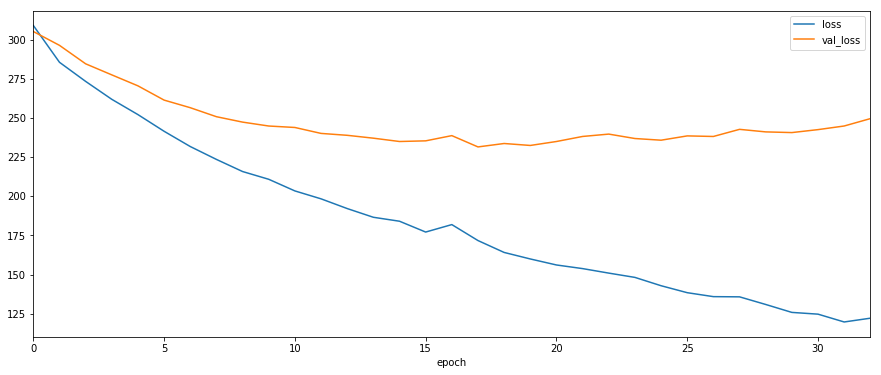

In [101]:
# If not retraining, history will not be available in the model.
# BaselineASR.plot_history()

# To plot using csv available from CSVLogger callback
df_hist = pd.read_csv(doc_dir+'BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.csv')
df_hist.set_index('epoch', inplace=True)
df_hist.plot(figsize=(15, 6))
plt.savefig(doc_dir+'BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.png', dpi=300)
plt.show()

Additionally, you may want to serialize both the model and weights.

In [102]:
# BaselineASR.save()

# Model Evaluation

Evaluate model on validation dataset.

In [11]:
# model = BaselineASR

model = BaselineASRModel(input_shape=(MAX_SEQ_LENGTH, 39), vocab_len=len(CharMap()), dir_path=model_dir, doc_path=doc_dir)
model.compile()
model.load(os.path.abspath(model_dir+"BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5")) # must provide abs path

Model directory is set to ../../models/Model010a/
Documentation directory is set to ../../docs/Model010a/

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_____________________________________

Prepare the dataset for evaluation.

In [12]:
train_generator = DataGenerator(input_dir=train_dir,
                                max_seq_length=MAX_SEQ_LENGTH,
                                max_label_length=MAX_LABEL_LENGTH,
                                ctc_input_length=CTC_INPUT_LENGTH,
                                char_to_idx_map=CHAR_TO_IDX_MAP,
                                batch_size=BATCH_SIZE)

validation_generator = DataGenerator(input_dir=valid_dir,
                                     max_seq_length=MAX_SEQ_LENGTH,
                                     max_label_length=MAX_LABEL_LENGTH,
                                     ctc_input_length=CTC_INPUT_LENGTH,
                                     char_to_idx_map=CHAR_TO_IDX_MAP,
                                     batch_size=BATCH_SIZE)

## Loss & WER Evaluation

Calculate model `loss` and `WER` for train and validation dataset.

In [13]:
train_loss, train_ctc_matrix = model.evaluate(train_generator, low_memory=True)
val_loss, val_ctc_matrix = model.evaluate(validation_generator, low_memory=True)

In [14]:
print(f"Train\tloss: {train_loss.mean():.3f}\tshape: {train_loss.shape}")
print(f"Valid\tloss: {val_loss.mean():.3f}\tshape: {val_loss.shape}")

Train	loss: 179.789	shape: (600, 1)
Valid	loss: 344.143	shape: (400, 1)


In [15]:
decoder = CTCDecoder(IDX_TO_CHAR_MAP)
decoder.fit(train_ctc_matrix)

CTCDecoder(idx_to_char_map={0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
                            6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
                            12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p',
                            17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u',
                            22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z',
                            27: '.', 28: ',', 29: '%'})

In [16]:
train_y_true = get_y_true_data_generator(IDX_TO_CHAR_MAP, train_generator)
train_y_preds = decoder.predict(train_ctc_matrix)
val_y_true = get_y_true_data_generator(IDX_TO_CHAR_MAP, validation_generator)
val_y_preds = decoder.predict(val_ctc_matrix)

D:\Anaconda2019\envs\gurih\lib\site-packages\tensorflow_core\python\framework\constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


KeyboardInterrupt: 

In [ ]:
train_wer = wer(train_y_true, train_y_preds)
val_wer = wer(val_y_true, val_y_preds)

In [62]:
print(f"Train\tloss: {train_loss.mean():.3f}\twer: {train_wer:.3f}\tshape: {train_loss.shape}")
print(f"Val\tloss: {val_loss.mean():.3f}\twer: {val_wer:.3f}\tshape: {val_loss.shape}")

Train	loss: 179.789	wer: 98.483	shape: (600, 1)
Val	loss: 344.143	wer: 98.700	shape: (400, 1)


Save evaluation metrics to `csv` files.

In [79]:
metrics = [
    ['train', train_loss.mean(), train_wer, train_loss.shape[0]],
    ['val', val_loss.mean(), val_wer, val_loss.shape[0]]
]
df_metrics = pd.DataFrame(metrics, columns=['dataset', 'loss', 'wer', 'num'])
df_metrics.to_csv(doc_dir+'metrics.csv', index=False, line_terminator='\n', sep=',')

# Performance on Test Dataset

Evaluate using test data.

\*\***IMPORTANT NOTICE**\*\*: 

Doing this will render your test set __obsolete__ as you would've already seen the datatest set you're about to evaluate. Please make sure you have optimize `bias-variance` tradeoff of the model using `validation` dataset before doing this analysis.

Choose which model you want to evaluate.

In [29]:
# model = BaselineASR

model = BaselineASRModel(input_shape=(MAX_SEQ_LENGTH, 39), vocab_len=len(CharMap()), dir_path=model_dir, doc_path=doc_dir)
model.compile()
model.load(os.path.abspath(model_dir+"BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29.h5")) # must provide abs path

Model directory is set to ../../models/Model010a/
Documentation directory is set to ../../docs/Model010a/

Model: "BaselineASR_f200_k11_s2_pvalid_nlstm200_ndense29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 3000, 39)]        0         
_________________________________________________________________
masking (Masking)            (None, 3000, 39)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1495, 200)         86000     
_________________________________________________________________
bidirectional (Bidirectional (None, 1495, 400)         641600    
_________________________________________________________________
the_output (TimeDistributed) (None, 1495, 30)          12030     
Total params: 739,630
Trainable params: 739,630
Non-trainable params: 0
_____________________________________

## Loss & WER Evaluation

Evaluate overall `loss` calculated from test set. Use decoder to get prediction str of input sequence and calculate word error rate.

In [30]:
test_dir = "../../dataset/interim/Model-010a/test/"
validate_dataset_dir(test_dir)

../../dataset/interim/Model-010a/test/ checks passed.


In [31]:
test_generator = DataGenerator(input_dir=test_dir,
                               max_seq_length=MAX_SEQ_LENGTH,
                               max_label_length=MAX_LABEL_LENGTH,
                               ctc_input_length=CTC_INPUT_LENGTH,
                               char_to_idx_map=CHAR_TO_IDX_MAP,
                               batch_size=8,
                               shuffle=False) # set to False to ensure correct alignment between y_true and y_pred

In [32]:
test_loss, test_ctc_matrix = model.evaluate(test_generator, low_memory=True)
decoder = CTCDecoder(IDX_TO_CHAR_MAP)
decoder.fit(test_ctc_matrix)

CTCDecoder(idx_to_char_map={0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
                            6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
                            12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p',
                            17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u',
                            22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z',
                            27: '.', 28: ',', 29: '%'})

In [33]:
y_true = get_y_true_data_generator(IDX_TO_CHAR_MAP, test_generator)
y_pred = decoder.predict(test_ctc_matrix)
test_wer = wer(y_true, y_pred)

D:\Anaconda2019\envs\gurih\lib\site-packages\tensorflow_core\python\framework\constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


KeyboardInterrupt: 

In [ ]:
print(f"Test\tloss: {test_loss.mean():.3f}\twer: {test_wer:.3f}\tshape: {test_loss.shape}")

Save test metrics results. This will append to metrics files created in Model Evaluation step.

In [ ]:
test_metric = ['test', test_loss.mean(), test_wer, test_loss.shape[0]]

In [ ]:
df_metrics = pd.read_csv(doc_dir+'metrics.csv')
df_metrics.loc[len(df_metrics)] = test_metric
df_metrics.to_csv(doc_dir+'metrics.csv', index=False, line_terminator='\n', sep=',')

## Sample Trancription Evaluation

Perform deeper analysis on sample transcription output.

In [15]:
sample_test_generator = DataGenerator(input_dir=test_dir,
                                      max_seq_length=MAX_SEQ_LENGTH,
                                      max_label_length=MAX_LABEL_LENGTH,
                                      ctc_input_length=CTC_INPUT_LENGTH,
                                      char_to_idx_map=CHAR_TO_IDX_MAP,
                                      batch_size=100000, # set large to load all or num examples you want from test_dir
                                      shuffle=False) # set to False to ensure correct alignment between y_true and y_pred

X_test = sample_test_generator[0][0]['the_input']
print(f"X_test shape: {X_test.shape}")

y_test = sample_test_generator[0][0]['the_labels']
y_test = np.array([''.join([IDX_TO_CHAR_MAP[c] for c in y]).strip() for y in y_test])
print(f"y_test shape: {y_test.shape}")

X_test shape: (11, 3000, 39)
y_test shape: (11,)


Get the `ctc_matrix`.

In [16]:
ctc_matrix = model.predict(X_test)
decoder = CTCDecoder(IDX_TO_CHAR_MAP)
decoder.fit(ctc_matrix)

D:\Anaconda2019\envs\gurih\lib\site-packages\tensorflow_core\python\framework\constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


CTCDecoder(idx_to_char_map={0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e',
                            6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k',
                            12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p',
                            17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u',
                            22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z',
                            27: '.', 28: ',', 29: '%'})

Get all predictions from ctc_matrix.

In [17]:
y_preds = decoder.predict(ctc_matrix)
len(y_preds)

11

Calculate and display word error rate.

In [18]:
idx_choice = 1
y_true = y_test[idx_choice]
y_pred = y_preds[idx_choice]

In [19]:
print(y_true)
print()
print(y_pred)

karena itu ia katakan allah menentang orang yang congkak, tetapi mengasihani orang yang rendah hati. karena itu tunduklah kepada allah, dan lawanlah iblis, maka ia akan lari dari padamu mendekatlah kepada allah, dan ia akan mendekat kepadamu.

iakatakan alah mnenkan orangan cunka tatingasyanil korangyang ingah ati kara itu teduklah ketadalalah kanawala i keis maka ia tkadahi da i pada nikala kepalah dan ia ken deka kpada mu


In [20]:
word_error_rate = wer(y_true, y_pred, html_filename="diff.html")
print('WER %.4f %%' % word_error_rate)

WER 89.1892 %


Display prediction errors. 
* Red colors are <span style="background-color:rgba(255, 0, 0, 0.23)">missing word</span>
* Green colors are <span style="background-color:rgba(0, 128, 0, 0.23)">insertion word</span>.
* Yellow colors are <span style="background-color:rgba(255, 165, 0, 0.5)">substitution word</span> and the references are in parenthesis.

In [21]:
with open("diff.html", 'r') as f:
    html = f.readlines()[0]
display(HTML(html))